In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_dirs = []
path_data = '/content/drive/MyDrive/raw_datacollection_B9'

for entry in os.scandir(path_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['/content/drive/MyDrive/raw_datacollection_B9/humans',
 '/content/drive/MyDrive/raw_datacollection_B9/others']

In [ ]:
classification_dict = {}
for img_dir in img_dirs:
    count = 1
    class_type = img_dir.split('/')[-1]
    print(class_type)
    
    classification_dict[class_type] = []
    print('generating dictionary for ',class_type)
    for count, filename in enumerate(os.listdir(img_dir)):
        file_path = path_data + class_type + '/' + filename
        classification_dict[class_type].append(file_path)

humans
generating dictionary for  humans
others
generating dictionary for  others


In [ ]:
class_dict = {}
count = 0
for class_type in classification_dict.keys():
    class_dict[class_type] = count
    count = count + 1
class_dict

{'humans': 0, 'others': 1}

In [ ]:
X, y = [], []
for class_type, training_files in classification_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        try:
            scalled_raw_img = cv2.resize(img, (50, 50)) # 32*32
            img_test = scalled_raw_img.reshape(50*50*3,1)
            X.append(img_test)
            y.append(class_dict[class_type]) 
        except Exception as e:
            pass

In [ ]:
len(X[0])

7500

In [ ]:
X = np.array(X).reshape(len(X),len(X[0])).astype(float)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
len(X_train)

1366

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7653508771929824

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       299
           1       0.67      0.62      0.65       157

    accuracy                           0.77       456
   macro avg       0.74      0.73      0.74       456
weighted avg       0.76      0.77      0.76       456



In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,13,15,20],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10,15]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.720358,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,logistic_regression,0.623724,{'logisticregression__C': 5}


In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.7653508771929824

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6491228070175439

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[251,  48],
       [ 59,  98]])

Text(69.0, 0.5, 'Truth')

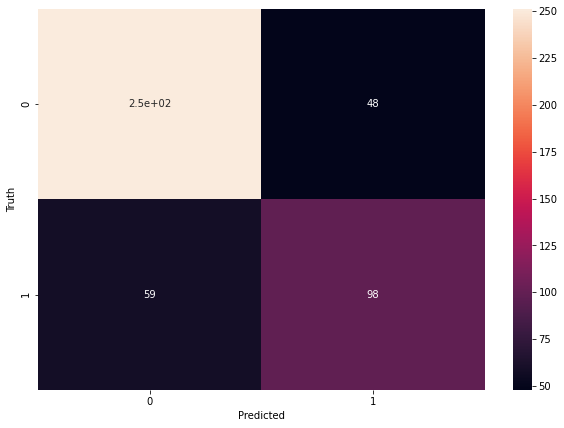

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
import joblib

In [ ]:
joblib.dump(best_clf, 'human_other_model_svm.pkl')

['human_other_model_svm.pkl']